In [1]:
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

# Setting up datasets

In [2]:
# Some starting code from Angel, mine required a 'seed' for training and eval datasets.
# Datasets going to training is roughly 70%.
new_kkanji_final_dataset_train = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="training",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 49420 files for training.


In [3]:
# Datasets going to training is roughly 30%.
new_kkanji_final_dataset_val = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="validation",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 21179 files for validation.


C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  func(*args, **kwargs)
C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  func(*args, **kwargs)
C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from current font.
  func(*args, **kwargs)
C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  func(*args, **kwargs)
C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from current font.
  func(*args, **kwargs)
C:\Users\lyjohn\anac

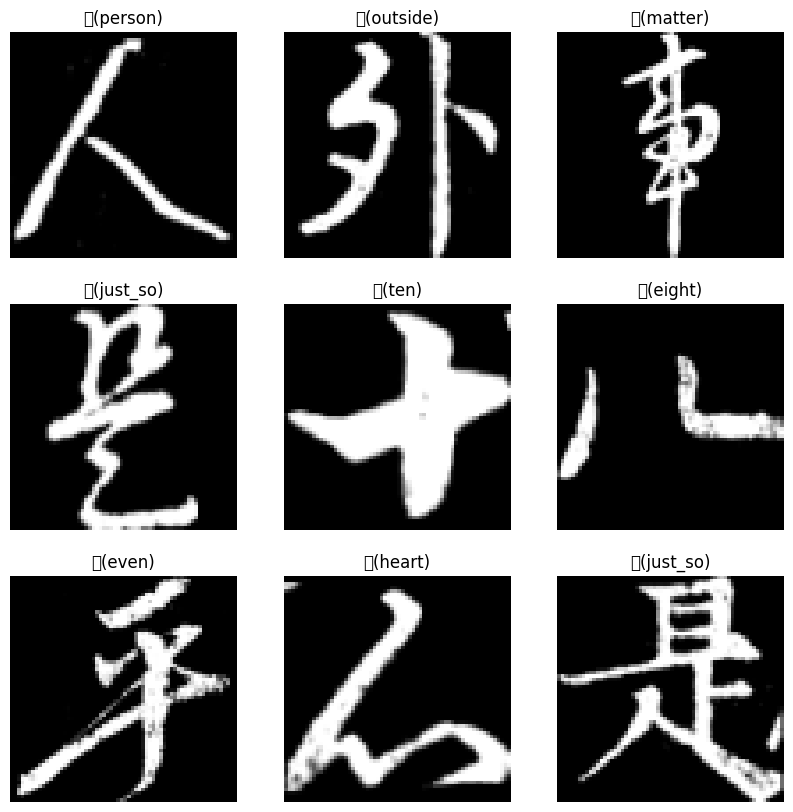

In [4]:
class_names = new_kkanji_final_dataset_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in new_kkanji_final_dataset_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in new_kkanji_final_dataset_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [6]:
"""# Normalize datasets
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

new_kkanji_final_dataset_train = new_kkanji_final_dataset_train.map(process)
new_kkanji_final_dataset_val = new_kkanji_final_dataset_val.map(process)
"""

'# Normalize datasets\ndef process(image,label):\n    image = tf.cast(image/255. ,tf.float32)\n    return image,label\n\nnew_kkanji_final_dataset_train = new_kkanji_final_dataset_train.map(process)\nnew_kkanji_final_dataset_val = new_kkanji_final_dataset_val.map(process)\n'

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = new_kkanji_final_dataset_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



     


0.0 1.0


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = new_kkanji_final_dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = new_kkanji_final_dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

# John's model

In [9]:
""" Before Optuna
john_model = models.Sequential()
# Add a CNN layer with 32 filters, 3x3 kernel, and activation slope of 'relu'.
# Image dimensions will be 64x64.
john_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# Use 2x2 pool to reduce size.
john_model.add(layers.AveragePooling2D((2, 2)))
john_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
john_model.add(layers.AveragePooling2D((2, 2)))
# Flatten the 2d to 1d layer.
john_model.add(layers.Flatten())
john_model.add(layers.Dense(64, activation='relu'))
# This number is related to the total number of options.
john_model.add(layers.Dense(150))
"""

# Before Optuna
john_model = models.Sequential()
# Add a CNN layer with 32 filters, 3x3 kernel, and activation slope of 'relu'.
# Image dimensions will be 64x64.
john_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# Use 2x2 pool to reduce size.
john_model.add(layers.AveragePooling2D((2, 2)))
john_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
john_model.add(layers.AveragePooling2D((2, 2)))
# Flatten the 2d to 1d layer.
john_model.add(layers.Flatten())
john_model.add(layers.Dense(64, activation='relu'))
# This number is related to the total number of options.
john_model.add(layers.Dense(150))

In [10]:
john_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

In [11]:
john_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

# Really useful in stopping the training early when no more progress
# is made after a certain amount of epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

john_history = john_model.fit(train_ds, 
                              epochs=20, 
                              callbacks=callback, 
                              validation_data=val_ds)

Epoch 1/20
1545/1545 [==============================] - 88s 57ms/step - loss: 2.8406 - accuracy: 0.4331 - val_loss: 1.2255 - val_accuracy: 0.6936
Epoch 2/20
1545/1545 [==============================] - 78s 51ms/step - loss: 0.8086 - accuracy: 0.7933 - val_loss: 0.7556 - val_accuracy: 0.8132
Epoch 3/20
1545/1545 [==============================] - 78s 50ms/step - loss: 0.4374 - accuracy: 0.8840 - val_loss: 0.7381 - val_accuracy: 0.8219
Epoch 4/20
1545/1545 [==============================] - 79s 51ms/step - loss: 0.2802 - accuracy: 0.9213 - val_loss: 0.8853 - val_accuracy: 0.8181
Epoch 5/20
1545/1545 [==============================] - 77s 50ms/step - loss: 0.2042 - accuracy: 0.9388 - val_loss: 0.9439 - val_accuracy: 0.8211
Epoch 6/20
1545/1545 [==============================] - 77s 50ms/step - loss: 0.1504 - accuracy: 0.9536 - val_loss: 1.0538 - val_accuracy: 0.8305


## Evaluate John's Model 

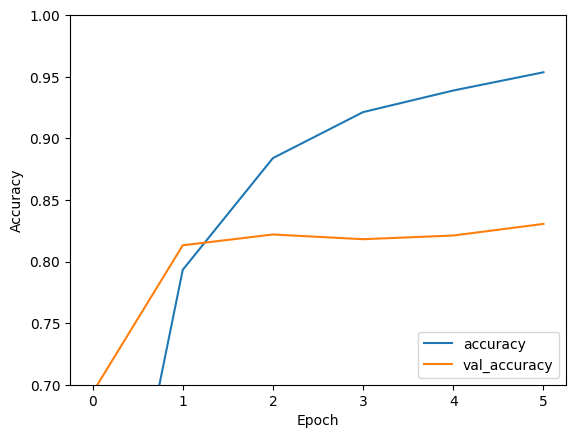

In [12]:
plt.plot(john_history.history['accuracy'], label='accuracy')
plt.plot(john_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')


In [13]:
john_model.save('john_model')

INFO:tensorflow:Assets written to: john_model\assets


INFO:tensorflow:Assets written to: john_model\assets


In [15]:
john_model_load = models.load_model('john_model')

In [16]:
john_model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

# Optuna

In [2]:
import numpy as np
import tensorflow as tf
import os
import optuna
import random

import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

In [3]:
# Some starting code from Angel, mine required a 'seed' for training and eval datasets.
# Datasets going to training is roughly 70%.
new_kkanji_final_dataset_train = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="training",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 49420 files for training.


In [4]:
# Datasets going to training is roughly 30%.
new_kkanji_final_dataset_val = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="validation",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 21179 files for validation.


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = new_kkanji_final_dataset_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = new_kkanji_final_dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = new_kkanji_final_dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
def objective(trial):
    first_layer_filter_num = trial.suggest_int('first_layer_filter_num', 8, 64)
    first_layer_kernel = trial.suggest_int('first_layer_kernel', 3, 4)
    first_layer_activation = trial.suggest_categorical('first_layer_activation', ['relu', 'sigmoid', 'tanh'])
    first_average_pooling_size = trial.suggest_int('first_average_pooling_size', 1, 4)
    second_layer_filter_num = trial.suggest_int('second_layer_filter_num', 8, 64)
    second_layer_kernel = trial.suggest_int('second_layer_kernel', 3, 4)
    second_layer_activation = trial.suggest_categorical('second_layer_activation', ['relu', 'sigmoid', 'tanh'])
    second_average_pooling_size = trial.suggest_int('second_average_pooling_size', 1, 4)
    dense_layer_size = trial.suggest_int('dense_layer_size', 4, 128)
    dense_layer_activation = trial.suggest_categorical('dense_layer_activation', ['relu', 'sigmoid', 'tanh'])
    
    model = models.Sequential()
    model.add(layers.Conv2D(first_layer_filter_num, (first_layer_kernel, first_layer_kernel), activation=first_layer_activation, input_shape=(64, 64, 3)))
    model.add(layers.AveragePooling2D((first_average_pooling_size, first_average_pooling_size)))
    model.add(layers.Conv2D(second_layer_filter_num, (second_layer_kernel, second_layer_kernel), activation=second_layer_activation))
    model.add(layers.AveragePooling2D((second_average_pooling_size, second_average_pooling_size)))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_layer_size, activation=dense_layer_activation))
    model.add(layers.Dense(150))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

    print(model.summary())

    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

    history = model.fit(train_ds, epochs=20,
                    callbacks=callback, validation_data=val_ds)

    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
    

[I 2022-12-06 21:31:51,023] A new study created in memory with name: no-name-6a3e4167-28cb-4354-9e00-9e7a176e069c


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 20)        560       
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 20)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 56)        17976     
                                                                 
 average_pooling2d_3 (Averag  (None, 12, 12, 56)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 8064)              0         
                                                                 
 dense_2 (Dense)             (None, 88)               

[I 2022-12-06 21:44:24,228] Trial 0 finished with value: 0.857311487197876 and parameters: {'first_layer_filter_num': 20, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 4, 'second_layer_filter_num': 56, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 1, 'dense_layer_size': 88, 'dense_layer_activation': 'tanh'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 28)        784       
                                                                 
 average_pooling2d_4 (Averag  (None, 62, 62, 28)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 59, 59, 29)        13021     
                                                                 
 average_pooling2d_5 (Averag  (None, 29, 29, 29)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 24389)             0         
                                                                 
 dense_4 (Dense)             (None, 59)               

[I 2022-12-06 22:05:20,655] Trial 1 finished with value: 0.025024788454174995 and parameters: {'first_layer_filter_num': 28, 'first_layer_kernel': 3, 'first_layer_activation': 'relu', 'first_average_pooling_size': 1, 'second_layer_filter_num': 29, 'second_layer_kernel': 4, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 2, 'dense_layer_size': 59, 'dense_layer_activation': 'relu'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 33)        924       
                                                                 
 average_pooling2d_6 (Averag  (None, 62, 62, 33)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 33)        9834      
                                                                 
 average_pooling2d_7 (Averag  (None, 60, 60, 33)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 118800)            0         
                                                                 
 dense_6 (Dense)             (None, 31)               

[I 2022-12-06 23:08:03,202] Trial 2 finished with value: 0.6589546203613281 and parameters: {'first_layer_filter_num': 33, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 1, 'second_layer_filter_num': 33, 'second_layer_kernel': 3, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 1, 'dense_layer_size': 31, 'dense_layer_activation': 'sigmoid'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 61, 61, 54)        2646      
                                                                 
 average_pooling2d_8 (Averag  (None, 61, 61, 54)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 59, 59, 39)        18993     
                                                                 
 average_pooling2d_9 (Averag  (None, 29, 29, 39)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 32799)             0         
                                                                 
 dense_8 (Dense)             (None, 49)               

[I 2022-12-06 23:27:52,227] Trial 3 finished with value: 0.022663960233330727 and parameters: {'first_layer_filter_num': 54, 'first_layer_kernel': 4, 'first_layer_activation': 'relu', 'first_average_pooling_size': 1, 'second_layer_filter_num': 39, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 2, 'dense_layer_size': 49, 'dense_layer_activation': 'tanh'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 45)        1260      
                                                                 
 average_pooling2d_10 (Avera  (None, 15, 15, 45)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 31)        12586     
                                                                 
 average_pooling2d_11 (Avera  (None, 13, 13, 31)       0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 5239)              0         
                                                                 
 dense_10 (Dense)            (None, 32)               

[I 2022-12-06 23:31:54,293] Trial 4 finished with value: 0.022663960233330727 and parameters: {'first_layer_filter_num': 45, 'first_layer_kernel': 3, 'first_layer_activation': 'sigmoid', 'first_average_pooling_size': 4, 'second_layer_filter_num': 31, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 1, 'dense_layer_size': 32, 'dense_layer_activation': 'tanh'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 61, 61, 36)        1764      
                                                                 
 average_pooling2d_12 (Avera  (None, 61, 61, 36)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 59, 59, 25)        8125      
                                                                 
 average_pooling2d_13 (Avera  (None, 29, 29, 25)       0         
 gePooling2D)                                                    
                                                                 
 flatten_6 (Flatten)         (None, 21025)             0         
                                                                 
 dense_12 (Dense)            (None, 84)               

[I 2022-12-07 00:24:33,164] Trial 5 finished with value: 0.17526794970035553 and parameters: {'first_layer_filter_num': 36, 'first_layer_kernel': 4, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 1, 'second_layer_filter_num': 25, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 2, 'dense_layer_size': 84, 'dense_layer_activation': 'relu'}. Best is trial 0 with value: 0.857311487197876.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 61, 61, 31)        1519      
                                                                 
 average_pooling2d_14 (Avera  (None, 30, 30, 31)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_15 (Conv2D)          (None, 27, 27, 19)        9443      
                                                                 
 average_pooling2d_15 (Avera  (None, 13, 13, 19)       0         
 gePooling2D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 3211)              0         
                                                                 
 dense_14 (Dense)            (None, 126)              

[I 2022-12-07 00:49:19,012] Trial 6 finished with value: 0.915671169757843 and parameters: {'first_layer_filter_num': 31, 'first_layer_kernel': 4, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 2, 'second_layer_filter_num': 19, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 2, 'dense_layer_size': 126, 'dense_layer_activation': 'sigmoid'}. Best is trial 6 with value: 0.915671169757843.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 59)        1652      
                                                                 
 average_pooling2d_16 (Avera  (None, 20, 20, 59)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 17, 17, 30)        28350     
                                                                 
 average_pooling2d_17 (Avera  (None, 4, 4, 30)         0         
 gePooling2D)                                                    
                                                                 
 flatten_8 (Flatten)         (None, 480)               0         
                                                                 
 dense_16 (Dense)            (None, 100)              

[I 2022-12-07 01:17:56,060] Trial 7 finished with value: 0.9218565821647644 and parameters: {'first_layer_filter_num': 59, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 3, 'second_layer_filter_num': 30, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 4, 'dense_layer_size': 100, 'dense_layer_activation': 'tanh'}. Best is trial 7 with value: 0.9218565821647644.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 50)        1400      
                                                                 
 average_pooling2d_18 (Avera  (None, 20, 20, 50)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, 18, 18, 12)        5412      
                                                                 
 average_pooling2d_19 (Avera  (None, 4, 4, 12)         0         
 gePooling2D)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 192)               0         
                                                                 
 dense_18 (Dense)            (None, 37)               

[I 2022-12-07 01:41:14,756] Trial 8 finished with value: 0.8731762766838074 and parameters: {'first_layer_filter_num': 50, 'first_layer_kernel': 3, 'first_layer_activation': 'sigmoid', 'first_average_pooling_size': 3, 'second_layer_filter_num': 12, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 4, 'dense_layer_size': 37, 'dense_layer_activation': 'tanh'}. Best is trial 7 with value: 0.9218565821647644.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 61, 61, 55)        2695      
                                                                 
 average_pooling2d_20 (Avera  (None, 61, 61, 55)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_21 (Conv2D)          (None, 58, 58, 34)        29954     
                                                                 
 average_pooling2d_21 (Avera  (None, 58, 58, 34)       0         
 gePooling2D)                                                    
                                                                 
 flatten_10 (Flatten)        (None, 114376)            0         
                                                                 
 dense_20 (Dense)            (None, 117)             

[I 2022-12-07 03:45:31,789] Trial 9 finished with value: 0.4265546202659607 and parameters: {'first_layer_filter_num': 55, 'first_layer_kernel': 4, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 1, 'second_layer_filter_num': 34, 'second_layer_kernel': 4, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 1, 'dense_layer_size': 117, 'dense_layer_activation': 'relu'}. Best is trial 7 with value: 0.9218565821647644.


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 62, 62, 13)        364       
                                                                 
 average_pooling2d_22 (Avera  (None, 20, 20, 13)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 17, 17, 48)        10032     
                                                                 
 average_pooling2d_23 (Avera  (None, 4, 4, 48)         0         
 gePooling2D)                                                    
                                                                 
 flatten_11 (Flatten)        (None, 768)               0         
                                                                 
 dense_22 (Dense)            (None, 92)              

[I 2022-12-07 03:56:20,775] Trial 10 finished with value: 0.9203456044197083 and parameters: {'first_layer_filter_num': 13, 'first_layer_kernel': 3, 'first_layer_activation': 'relu', 'first_average_pooling_size': 3, 'second_layer_filter_num': 48, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 4, 'dense_layer_size': 92, 'dense_layer_activation': 'tanh'}. Best is trial 7 with value: 0.9218565821647644.


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 62, 62, 8)         224       
                                                                 
 average_pooling2d_24 (Avera  (None, 20, 20, 8)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_25 (Conv2D)          (None, 17, 17, 54)        6966      
                                                                 
 average_pooling2d_25 (Avera  (None, 4, 4, 54)         0         
 gePooling2D)                                                    
                                                                 
 flatten_12 (Flatten)        (None, 864)               0         
                                                                 
 dense_24 (Dense)            (None, 97)              

[I 2022-12-07 04:05:46,770] Trial 11 finished with value: 0.9167571663856506 and parameters: {'first_layer_filter_num': 8, 'first_layer_kernel': 3, 'first_layer_activation': 'relu', 'first_average_pooling_size': 3, 'second_layer_filter_num': 54, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 4, 'dense_layer_size': 97, 'dense_layer_activation': 'tanh'}. Best is trial 7 with value: 0.9218565821647644.


In [25]:
print(f'Best trial info:\n{study.best_trial}\n')
for param, value in study.best_params.items():
    print(f'Param: {param}\tValue: {value}')

Best trial info:
FrozenTrial(number=7, values=[0.9218565821647644], datetime_start=datetime.datetime(2022, 12, 7, 0, 49, 19, 12754), datetime_complete=datetime.datetime(2022, 12, 7, 1, 17, 56, 59926), params={'first_layer_filter_num': 59, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 3, 'second_layer_filter_num': 30, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 4, 'dense_layer_size': 100, 'dense_layer_activation': 'tanh'}, distributions={'first_layer_filter_num': IntDistribution(high=64, log=False, low=8, step=1), 'first_layer_kernel': IntDistribution(high=4, log=False, low=3, step=1), 'first_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 'tanh')), 'first_average_pooling_size': IntDistribution(high=4, log=False, low=1, step=1), 'second_layer_filter_num': IntDistribution(high=64, log=False, low=8, step=1), 'second_layer_kernel': IntDistribution(high=4, log=False, low=3, step

In [26]:
# %autosave 180

In [7]:
# Using Optuna results
john_model = models.Sequential()
john_model.add(layers.Conv2D(59, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
john_model.add(layers.AveragePooling2D((3, 3)))
john_model.add(layers.Conv2D(30, (4, 4), activation='tanh'))
john_model.add(layers.AveragePooling2D((4, 4)))
john_model.add(layers.Flatten())
john_model.add(layers.Dense(100, activation='tanh'))
john_model.add(layers.Dense(150))

In [8]:
john_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 59)        1652      
                                                                 
 average_pooling2d (AverageP  (None, 20, 20, 59)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 30)        28350     
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 30)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 100)               4

In [9]:
john_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

# Really useful in stopping the training early when no more progress
# is made after a certain amount of epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

john_history = john_model.fit(train_ds, 
                              epochs=20, 
                              callbacks=callback, 
                              validation_data=val_ds)

Epoch 1/20
1545/1545 [==============================] - 103s 66ms/step - loss: 1.5890 - accuracy: 0.6738 - val_loss: 0.7210 - val_accuracy: 0.8415
Epoch 2/20
1545/1545 [==============================] - 92s 59ms/step - loss: 0.5546 - accuracy: 0.8782 - val_loss: 0.4907 - val_accuracy: 0.8870
Epoch 3/20
1545/1545 [==============================] - 88s 57ms/step - loss: 0.3838 - accuracy: 0.9131 - val_loss: 0.4284 - val_accuracy: 0.8970
Epoch 4/20
1545/1545 [==============================] - 86s 56ms/step - loss: 0.2997 - accuracy: 0.9319 - val_loss: 0.3808 - val_accuracy: 0.9065
Epoch 5/20
1545/1545 [==============================] - 87s 57ms/step - loss: 0.2462 - accuracy: 0.9438 - val_loss: 0.3546 - val_accuracy: 0.9117
Epoch 6/20
1545/1545 [==============================] - 90s 59ms/step - loss: 0.2046 - accuracy: 0.9540 - val_loss: 0.3371 - val_accuracy: 0.9132
Epoch 7/20
1545/1545 [==============================] - 88s 57ms/step - loss: 0.1744 - accuracy: 0.9618 - val_loss: 0.3303 

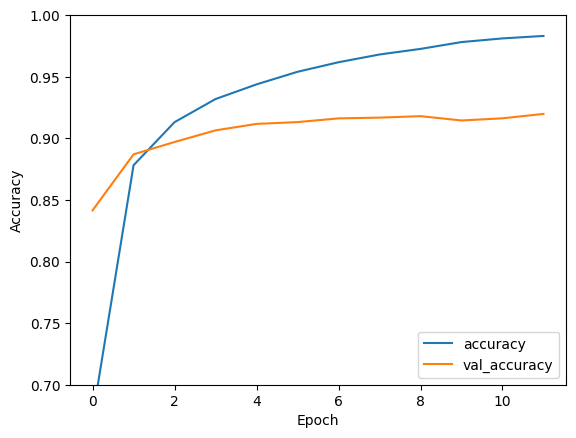

In [10]:
plt.plot(john_history.history['accuracy'], label='accuracy')
plt.plot(john_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')


In [11]:
john_model.save('john_optuna_model')

INFO:tensorflow:Assets written to: john_optuna_model\assets


INFO:tensorflow:Assets written to: john_optuna_model\assets


In [12]:
john_model_load = models.load_model('john_optuna_model')

In [13]:
john_model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 59)        1652      
                                                                 
 average_pooling2d (AverageP  (None, 20, 20, 59)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 30)        28350     
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 30)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 100)               4